In [21]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load dataset
data = pd.read_csv('Nat_Gas (2).csv')

# Display initial data
data.head()


,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


C:\Users\ashbo\AppData\Local\Temp\ipykernel_27788\1620922368.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Dates'] = pd.to_datetime(data['Dates'])


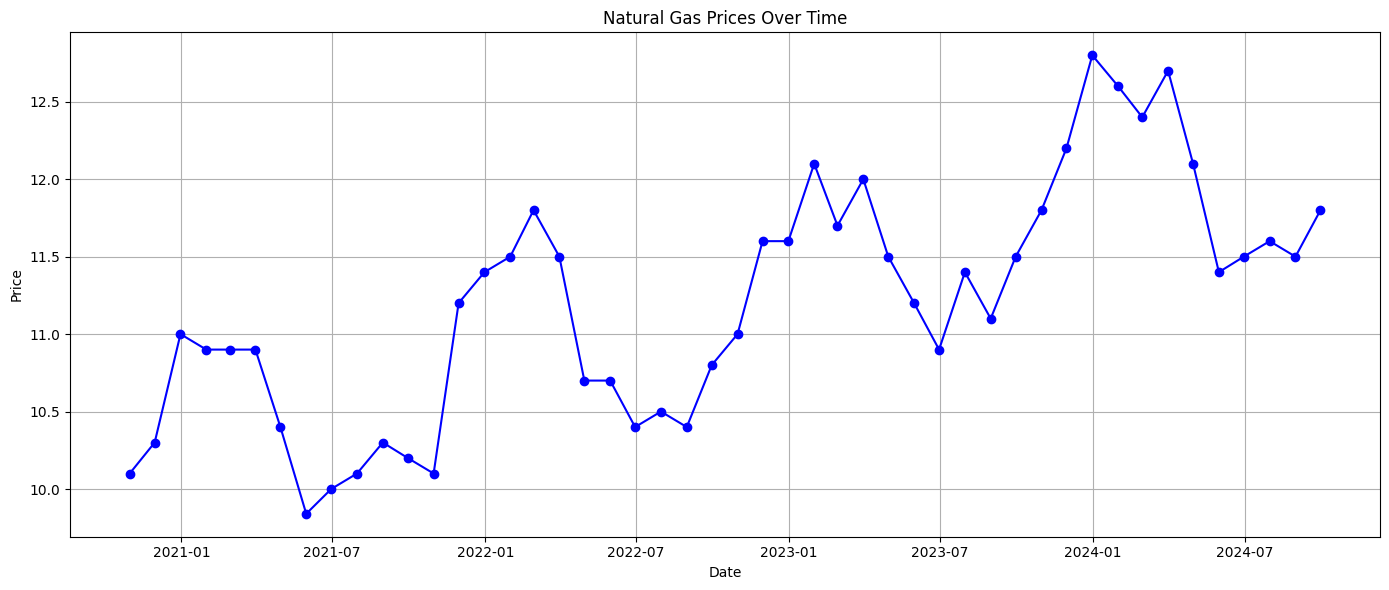

In [22]:
# Convert 'Dates' column to datetime for better visualization
data['Dates'] = pd.to_datetime(data['Dates'])

# Plot price evolution
plt.figure(figsize=(14, 6))
plt.plot(data['Dates'], data['Prices'], marker='o', linestyle='-', color='b')
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
%pip install statsmodels


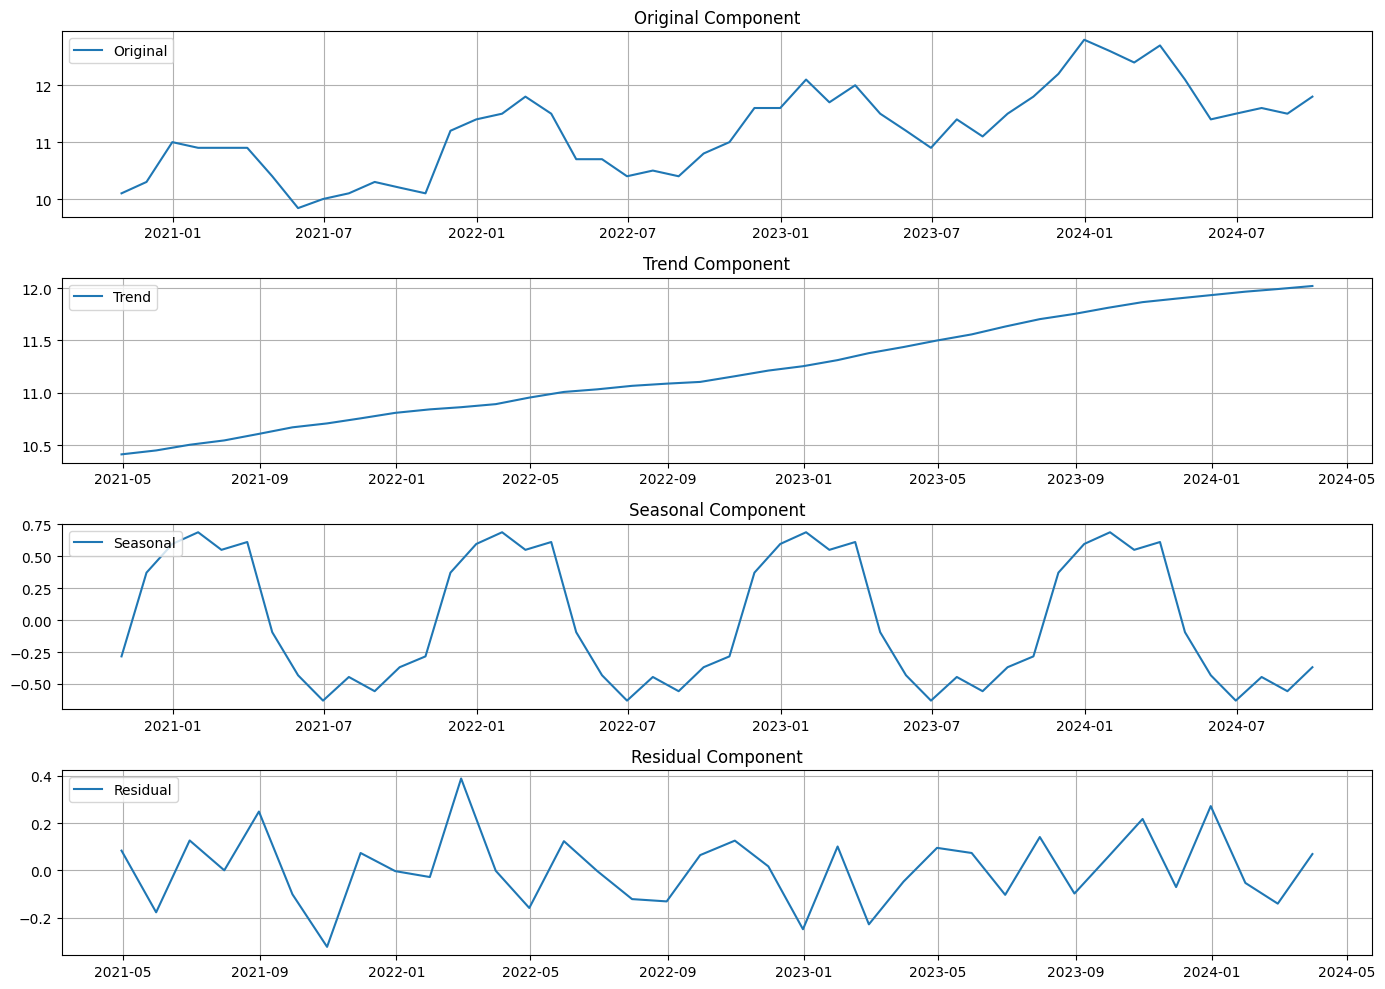

In [24]:
# Decompose the time series to study its components
decomposition = seasonal_decompose(data['Prices'], period=12)  # Assuming yearly seasonality with monthly data

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

labels = ['Original', 'Trend', 'Seasonal', 'Residual']
components = [data['Prices'], decomposition.trend, decomposition.seasonal, decomposition.resid]

for i, ax in enumerate(axes):
    ax.plot(data['Dates'], components[i], label=labels[i])
    ax.legend(loc='upper left')
    ax.set_title(f"{labels[i]} Component")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Test stationarity of the series
def is_stationary(timeseries):
    """Check stationarity using the Augmented Dickey-Fuller test."""
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1] <= 0.05

# Check original and differenced series
is_stationary_original = is_stationary(data['Prices'])
data['First Difference'] = data['Prices'].diff()
is_stationary_first_diff = is_stationary(data['First Difference'].dropna())

is_stationary_original, is_stationary_first_diff



(False, True)

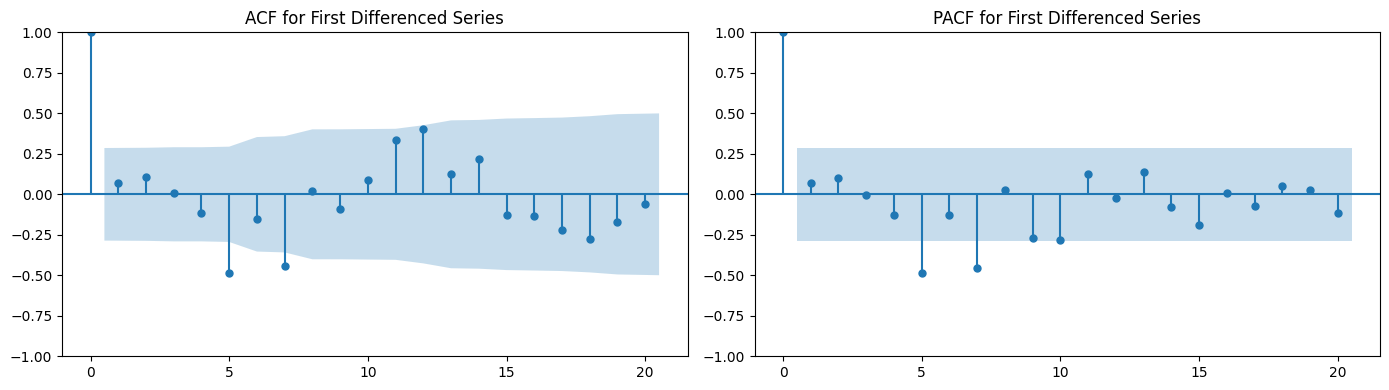

In [26]:
# Plot ACF and PACF for insights into AR and MA terms
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(data['First Difference'].dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF for First Differenced Series')
plot_pacf(data['First Difference'].dropna(), lags=20, ax=axes[1])
axes[1].set_title('PACF for First Differenced Series')
plt.tight_layout()
plt.show()



In [27]:
# Fit SARIMA model
model = SARIMAX(data['Prices'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=-1)
results.summary()


c:\Users\ashbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -0.641
Date:                            Thu, 17 Aug 2023   AIC                             11.281
Time:                                    21:53:47   BIC                             19.058
Sample:                                         0   HQIC                            13.966
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2254      0.275     -0.821      0.412      -0.763       0.313
ma.L1         -0.7655      0.206     -3.711      0.000      -1.170      -0.361
ar.S.L12      -0.1637      0.431     -0.380      0.704      -1.009       0.681
ma.S.L12      -0.9801     25.025     -0.039      0.969     -50.028      48.068
sigma2         0.0343      0.847      0.040      0.968      -1.625       1.694
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.82   Prob(JB):                         0.71
Heteroskedasticity (H):               0.82   Skew:                            -0.11
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

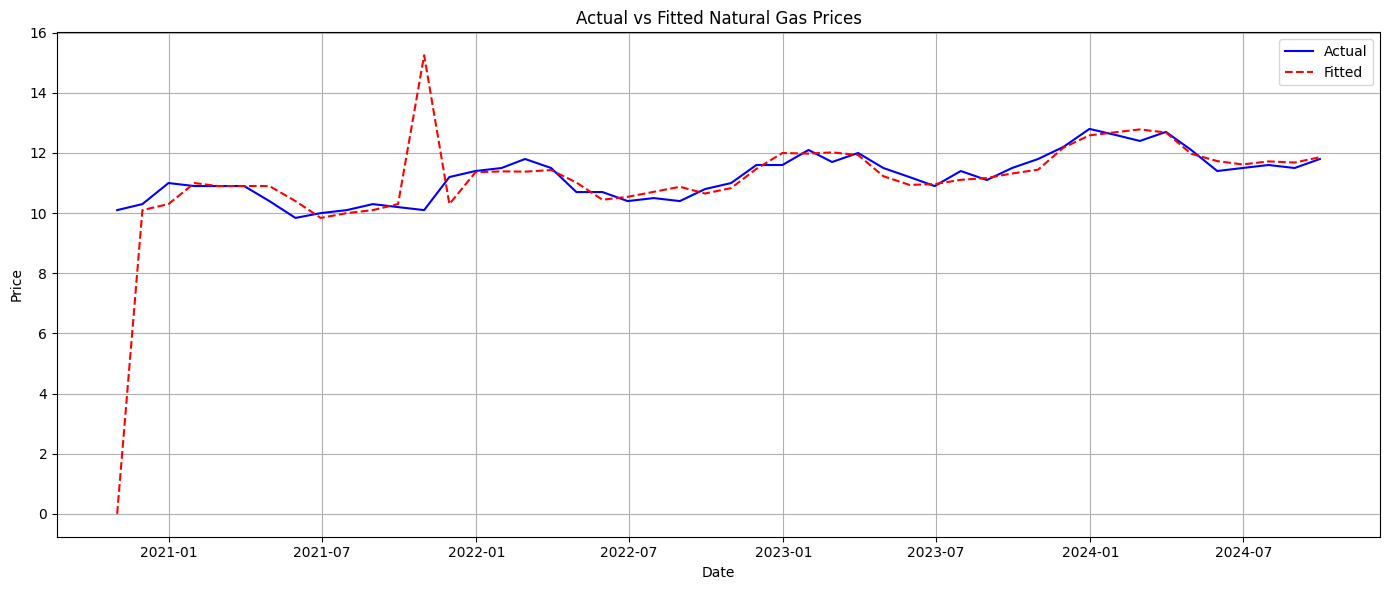

In [28]:
# Compare actual and fitted values
data['Fitted'] = results.fittedvalues

plt.figure(figsize=(14, 6))
plt.plot(data['Dates'], data['Prices'], label='Actual', color='blue')
plt.plot(data['Dates'], data['Fitted'], label='Fitted', color='red', linestyle='--')
plt.title('Actual vs Fitted Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


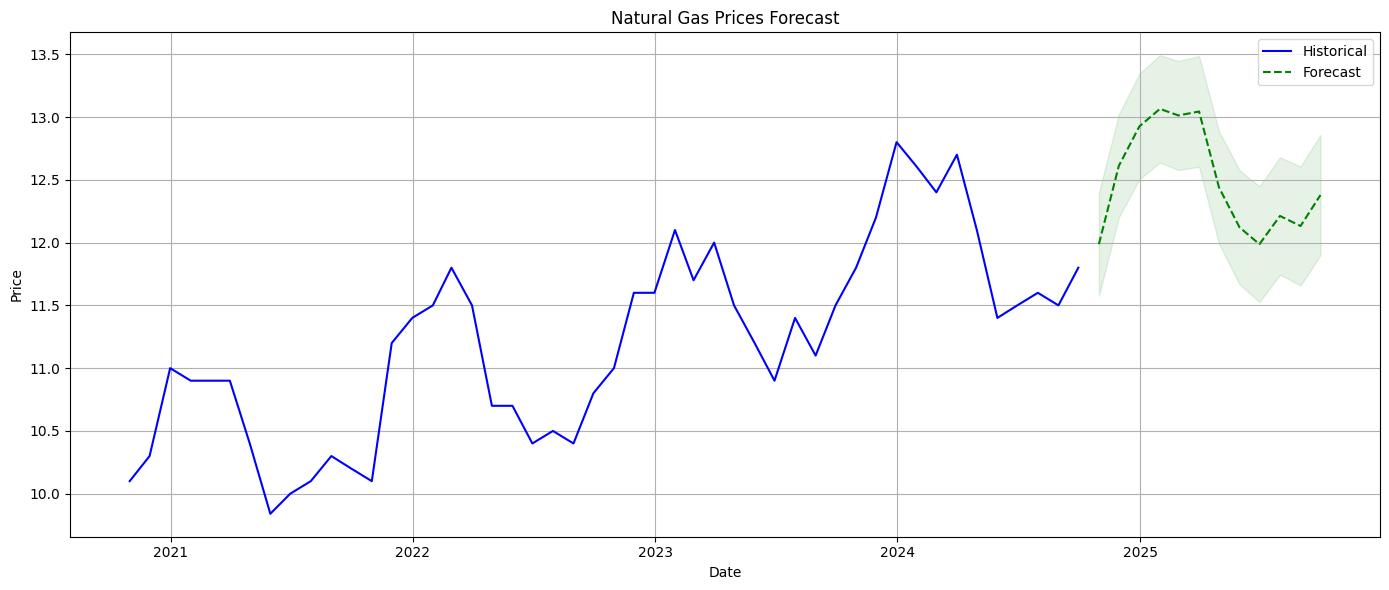

In [34]:
# Forecast for the next year
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(data['Dates'].iloc[-1] + pd.Timedelta(days=1), periods=12, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

plt.figure(figsize=(14, 6))
plt.plot(data['Dates'], data['Prices'], label='Historical', color='blue')
plt.plot(forecast_index, forecast_series, label='Forecast', color='green', linestyle='--')
plt.fill_between(forecast_index, forecast.conf_int()['lower Prices'], forecast.conf_int()['upper Prices'], color='green', alpha=0.1)
plt.title('Natural Gas Prices Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
